In [246]:
#!pip install statsmodels
import numpy as np
import pandas as pd
from pandas import Series
import datetime
from sklearn import linear_model
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import operator

In [245]:
sessions_df = pd.read_json("./../data/raw/sessions.jsonl", lines=True)
sessions_df.set_index('session_id', inplace=True)

In [247]:
product_df = pd.read_json("./../data/raw/products.jsonl", lines=True)
product_df.set_index('product_id', inplace=True)
product_df = product_df.replace([np.inf, -np.inf], np.nan)
product_df = product_df.dropna(subset=["price"])
product_df = product_df[product_df.price >= 0]

In [248]:
def get_products_bought_in_week(week_number, df, sessions_df):
    products = []
    x = df.loc[df['weeks_from_start'] == week_number].index.values
    start = x[0]
    product_list = list(sessions_df['product_id'])
    end = start + np.timedelta64(6,'D')
    sessions_df = sessions_df[(sessions_df['event_type'] == "BUY_PRODUCT")]
    for i, date in enumerate(sessions_df['timestamp']):
        date = np.datetime64(date)
        if start <= date <= end:
            products.append(product_list[i])
    return products

In [249]:
def create_weeks(df):
    dates = df['timestamp']
    dates = pd.to_datetime(dates)
    dates = dates.dt.to_period('W')
    dates = dates.drop_duplicates()
    dates = dates.sort_values()
    return dates

In [250]:
def split_data(y, split_ratio = 0.8):
    split_n = int(split_ratio*len(y))
    train = y.iloc[:split_n]
    test = y.iloc[split_n:]
    return train, test

In [251]:
def calculate_week_number(date = datetime.date.today()):
    first_date = create_weeks(sessions_df).values[0].start_time.date()
    return (date - first_date).days//7

In [252]:
def product_bought(product_id, df, dates, df_price = product_df):
    product_amount = df[(df['event_type'] == "BUY_PRODUCT") & (df['product_id'] == product_id)]
    
    daterange_df = pd.DataFrame()
    time_list = [(dates.values[i].start_time, dates.values[i].end_time) for i in range(len(dates))]
    daterange_df['count'] = [product_amount['timestamp'].between(s, e).sum() for s, e in time_list]
    daterange_df['price'] = list(product_df[product_df.index == 1114]['price'])[0]
    daterange_df['discount'] = 0
    keys = product_amount.index
    for i, time in enumerate(product_amount['timestamp']):
        product_amount['timestamp'][keys[i]] = calculate_week_number(time.date())
    keys_t = list(product_amount['timestamp'])
    j = 0
    for i in daterange_df.index:
        if i in keys_t:
            daterange_df['discount'][i] = product_amount['offered_discount'][keys[j]]
            j += 1
    return daterange_df

In [253]:
def prepare_dataframe(df):
    dates = create_weeks(df)
    weeks = dates.values
    df3 = pd.DataFrame()
    df3['date'] = [weeks[i].start_time for i in range(len(weeks))]
    df2 = pd.DataFrame(index = df3['date'])
    df2['weeks_from_start'] = ((df2.index - df2.index[0]).days)//7
    return df2, dates

In [254]:
def prepare_data(product_id, df, source_df, dates):
    x = df['weeks_from_start'].values.reshape(-1, 1)
    y = product_bought(product_id, source_df, dates)['count'].values
    return x, y

In [255]:
def fit_model(dataset):
    model=ARIMA(dataset, order=(1,1,1))
    model_fit=model.fit()
    return model_fit

In [256]:
def get_model_summary(model):
    return model.summary()

In [257]:
def add_empty_rows(df, amount):
    for i in range(amount+1):
        df.loc[len(df)] = 0
    return df

In [258]:
def plot_autocorrelation(dataset):
    autocorrelation_plot(dataset)
    plt.show()

In [259]:
def predict(start_week, end_week, df, model):
    while end_week > len(df):
        df = add_empty_rows(df, end_week - len(df))
    df['forecast']=model.predict(start=start_week,end=end_week,dynamic=True)
    return df

In [260]:
def predict_products(sessions_df, week_number):
    products_predictions = {}
    product_list = list(sessions_df['product_id'])
    product_list = list(dict.fromkeys(product_list))
    df, dates = prepare_dataframe(sessions_df)
    for product in product_list:
        y = product_bought(product, sessions_df, dates)
        train, test = split_data(y)
        model_fit = fit_model(train['count'])
        predicted = predict(week_number-1, week_number+1, train, model_fit)
        products_predictions[product] = predicted['forecast'][week_number]
    return products_predictions

In [261]:
def calculate_success_criterion(week_number, item_amount = 150):
    predictions = predict_products(sessions_df, week_number)
    sorted_d = dict(sorted(predictions.items(), key=operator.itemgetter(1),reverse=True))
    best_products = dict(list(sorted_d.items())[:item_amount])
    chosen_products = list(best_products.keys())
    df, dates = prepare_dataframe(sessions_df)
    bought_products = get_products_bought_in_week(week_number, df, sessions_df)
    same = (set(chosen_products) & set(bought_products))
    diff = set(bought_products) - set(chosen_products)
    all = len(diff) + len(chosen_products)
    return len(same)/all

In [262]:
def get_products_viewed_in_week(week_number, df, sessions_df):
    products = []
    x = df.loc[df['weeks_from_start'] == week_number].index.values
    start = x[0]
    product_list = list(sessions_df['product_id'])
    end = start + np.timedelta64(6,'D')
    sessions_df = sessions_df[(sessions_df['event_type'] == "VIEW_PRODUCT")]
    for i, date in enumerate(sessions_df['timestamp']):
        date = np.datetime64(date)
        if start <= date <= end:
            products.append(product_list[i])
    return products

In [263]:
def product_viewed(product_id, df, dates, df_price = product_df):
    viewed = df[(df['event_type'] == "VIEW_PRODUCT") & (df['product_id'] == product_id)]
    product_amount = df[(df['event_type'] == "BUY_PRODUCT") & (df['product_id'] == product_id)]
    daterange_df = pd.DataFrame()
    time_list = [(dates.values[i].start_time, dates.values[i].end_time) for i in range(len(dates))]
    daterange_df['count'] = [product_amount['timestamp'].between(s, e).sum() for s, e in time_list]
    daterange_df['viewed'] = [viewed['timestamp'].between(s, e).sum() for s, e in time_list]
    daterange_df['price'] = list(product_df[product_df.index == 1114]['price'])[0]
    daterange_df['discount'] = 0
    keys = product_amount.index
    for i, time in enumerate(product_amount['timestamp']):
        product_amount['timestamp'][keys[i]] = calculate_week_number(time.date())
    keys = viewed.index
    print(len(viewed['timestamp']))
    for i, time in enumerate(viewed['timestamp']):
        print(i)
        viewed['timestamp'][keys[i]] = calculate_week_number(time.date())
    keys_t = list(viewed['timestamp'])
    # keys = viewed.index
    j = 0
    for i in daterange_df.index:
        if i in keys_t:
            daterange_df['discount'][i] = viewed['offered_discount'][keys[j]]
            j += 1
    return daterange_df

In [264]:
products_predictions = {}
product_list = list(sessions_df['product_id'])
product_list = list(dict.fromkeys(product_list))
df, dates = prepare_dataframe(sessions_df)
product = 1114
y = product_bought(product, sessions_df, dates)
y.head(10)

ipykernel_launcher:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ewaka\Anaconda3\lib\site-packages\pandas\core\series.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_labels(key, value)
ipykernel_launcher:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

,count,price,discount
0,0,32.99,0
1,0,32.99,0
2,0,32.99,0
3,0,32.99,0
4,0,32.99,0
5,1,32.99,5
6,0,32.99,0
7,0,32.99,0
8,0,32.99,0
9,0,32.99,0


In [265]:
#!pip install hana_ml
from hana_ml.algorithms.pal.tsa.vector_arima import VectorARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
# !pip install pmdarima
from pmdarima import auto_arima
# !pip install pmdarima
from pmdarima.arima import auto_arima
import os
import sys
import warnings
from datetime import date

import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from numpy import cumsum, log, polyfit, sqrt, std, subtract

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm

from scipy.stats import spearmanr, pearsonr
from scipy.stats import probplot, moment

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [266]:
pq = []
for name, column in y[['count', 'price', 'discount']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(y[name],start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : count
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=85.413, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=99.983, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=94.044, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=95.773, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=87.410, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=87.410, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=95.655, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=93.855, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=85.076, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=88.061, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=87.603, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=87.073, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=87.073, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0] i

C:\Users\ewaka\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=727.275, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=727.273, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=737.994, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=735.223, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=728.641, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=725.911, Time=0.17 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.965 seconds
optimal order for:discount is: (1, 0, 1) 




In [268]:
# mod = sm.tsa.VARMAX(y[['count', 'price', 'discount']], order=(0,2,1), error_cov_type='diagonal')
# res = mod.fit(maxiter=1000, disp=False)

# model = VARMAX(y[['count', 'discount']], order=(1, 2))
# model_fit = model.fit(y['count'])
# model = SARIMAX(y, order=(1, 0, 2), exog=y['count'])

# model = VARMAX(y, order=(1, 2))
# model_fit = model.fit(y,  disp=False)

# model = sm.tsa.VARMAX(list(y['count']), order=(1,0), trend='c')
# model_result = model.fit(maxiter=1000, disp=False)

model = auto_arima(y, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y)

# model = VAR(y)
# model_fit = model.fit()

# model = ARIMA(y['Act'], order=(1, 1, 1))
# model_fit = model.fit(disp=False)

ValueError: y should be a 1d array, got an array of shape (124, 3) instead.

In [ ]:
# model = fit_model(y)
# https://blogs.sap.com/2021/05/06/a-multivariate-time-series-modeling-and-forecasting-guide-with-python-machine-learning-client-for-sap-hana/

In [ ]:
calculate_success_criterion(100)

ipykernel_launcher:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ewaka\Anaconda3\lib\site-packages\pandas\core\series.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_labels(key, value)
ipykernel_launcher:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

0.43352601156069365

In [270]:
def hurst(ts):
    lags = range(2, 100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

In [271]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [272]:
def create_weeks(df):
    dates = df['timestamp']
    dates = pd.to_datetime(dates)
    dates = dates.dt.to_period('W')
    dates = dates.drop_duplicates()
    dates = dates.sort_values()
    return dates

C:\Users\ewaka\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


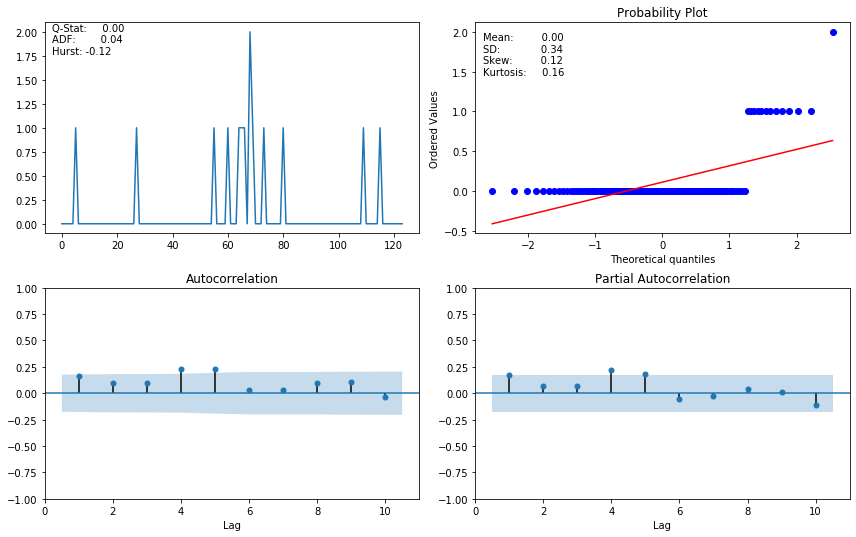

In [273]:
plot_correlogram(y['count'])

In [274]:
# !pip install seaborn
import seaborn as sns

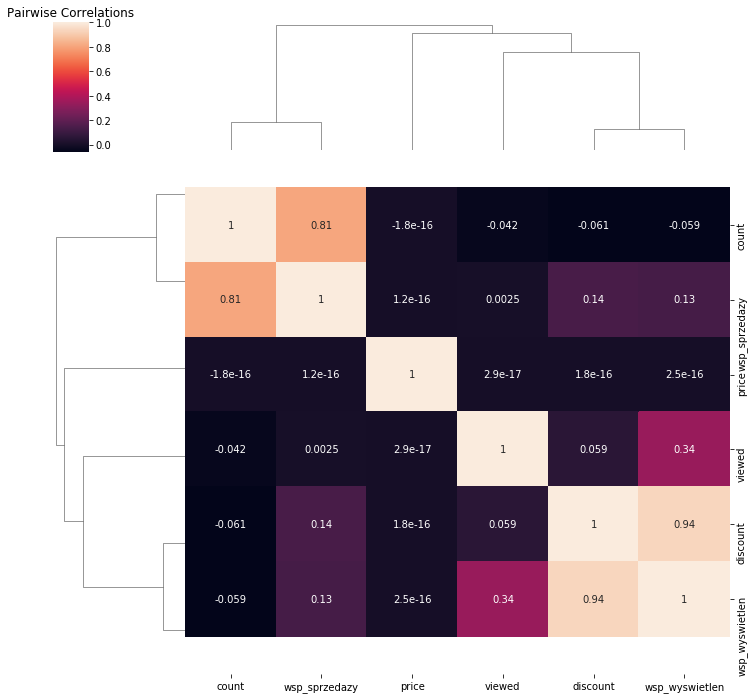

C:\Users\ewaka\Anaconda3\lib\site-packages\numpy\core\function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y = y * step
C:\Users\ewaka\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  :math:`Ax = b`," i.e., if :math:`\\bar{x}` is said solution, then
C:\Users\ewaka\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  part = a.ravel()


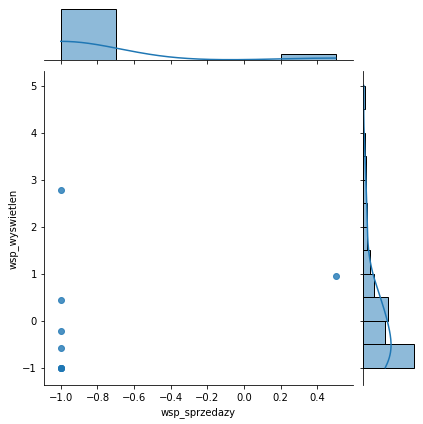

In [275]:
df = z
g = sns.clustermap(df.corr(), annot=True)
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pairwise Correlations')
plt.show()

sns.jointplot(x=df["wsp_sprzedazy"].pct_change().dropna(), y=df['wsp_wyswietlen'].pct_change().dropna(), kind="reg")

In [276]:
delivery_df = pd.read_json("./../data/raw/deliveries.jsonl", lines=True)
delivery_df.set_index('purchase_id', inplace=True)
delivery_df = delivery_df.replace([np.inf, -np.inf], np.nan)
delivery_df = delivery_df.dropna(subset=["delivery_company", 'delivery_timestamp'])
delivery_df['purchase_timestamp'] = pd.to_datetime(delivery_df['purchase_timestamp'])
delivery_df['delivery_timestamp'] = pd.to_datetime(delivery_df['delivery_timestamp'])
delivery_df['delivery_company'] = delivery_df["delivery_company"].astype(int)
delivery_df

,purchase_timestamp,delivery_timestamp,delivery_company
purchase_id,,,
20001,2019-12-30 09:36:24,2020-01-03 09:38:59,516
20002,2019-12-31 23:15:05,2020-01-04 23:19:26,516
20003,2019-12-31 15:32:45,2020-01-05 15:34:16,516
20004,2019-12-31 14:39:52,2020-01-02 14:40:49,516
20005,2019-12-30 03:19:36,2020-01-04 03:21:24,360
...,...,...,...
37399,2021-01-01 01:51:17,2021-01-03 01:54:02,360
37400,2021-01-02 12:37:29,2021-01-06 12:40:42,360
37401,2021-01-02 06:42:06,2021-01-07 06:46:20,360


In [277]:
df, dates = prepare_dataframe(sessions_df)
z = product_viewed(1114, sessions_df, dates)

ipykernel_launcher:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ewaka\Anaconda3\lib\site-packages\pandas\core\series.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_labels(key, value)
ipykernel_launcher:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3935
0
1


ipykernel_launcher:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

ipykernel_launcher:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [278]:
z['wsp_sprzedazy'] = z['count']*z['price']*z['discount']
z['wsp_wyswietlen'] = z['viewed']*z['price']*z['discount']

In [279]:
z.head(10)

,count,viewed,price,discount,wsp_sprzedazy,wsp_wyswietlen
0,0,11,32.99,5,0.0,1814.45
1,0,26,32.99,10,0.0,8577.40
2,0,38,32.99,15,0.0,18804.30
3,0,35,32.99,15,0.0,17319.75
4,0,45,32.99,15,0.0,22268.25
5,1,32,32.99,10,329.9,10556.80
6,0,23,32.99,20,0.0,15175.40
7,0,24,32.99,5,0.0,3958.80
8,0,36,32.99,20,0.0,23752.80
9,0,17,32.99,20,0.0,11216.60


In [280]:
product_from_category_df = pd.merge(sessions_df, product_df, on='product_id', how='inner')
product_id = 1114
category = product_from_category_df[product_from_category_df['product_id'] == product_id]['category_path'][0]

product_from_category_df = pd.merge(sessions_df, product_df, on='product_id', how='inner')
df = product_from_category_df[product_from_category_df['event_type'] == "BUY_PRODUCT"]
df = df[df['category_path'] == category]
# print(df)

In [296]:
z.drop('price', axis=1)

,count,viewed,discount,wsp_sprzedazy,wsp_wyswietlen
0,0,11,5,0.0,1814.45
1,0,26,10,0.0,8577.40
2,0,38,15,0.0,18804.30
3,0,35,15,0.0,17319.75
4,0,45,15,0.0,22268.25
...,...,...,...,...,...
119,0,30,5,0.0,4948.50
120,0,35,0,0.0,0.00
121,0,26,10,0.0,8577.40
122,0,23,0,0.0,0.00


In [298]:
z.drop('wsp_sprzedazy', axis=1)
z.drop('wsp_wyswietlen', axis=1)

,count,viewed,price,discount,wsp_sprzedazy
0,0,11,32.99,5,0.0
1,0,26,32.99,10,0.0
2,0,38,32.99,15,0.0
3,0,35,32.99,15,0.0
4,0,45,32.99,15,0.0
...,...,...,...,...,...
119,0,30,32.99,5,0.0
120,0,35,32.99,0,0.0
121,0,26,32.99,10,0.0
122,0,23,32.99,0,0.0


In [299]:
from statsmodels.tsa.stattools import adfuller

print(z.ndim)
dftest = adfuller(z, autolag = 'AIC')
dftest[1]

2


ValueError: x is required to have ndim 1 but has ndim 2

In [300]:
step_fit = auto_arima(z['count'], trace = True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=87.259, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=89.085, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=87.603, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=88.061, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=99.983, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=87.073, Time=0.60 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=89.392, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=85.076, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=87.073, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=88.984, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=85.413, Time=0.16 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 2.760 seconds


In [301]:
model = ARIMA(z['count'], order = (1,0,5))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                  124
Model:                 ARIMA(1, 0, 5)   Log Likelihood                 -35.143
Date:                Fri, 14 Jan 2022   AIC                             86.286
Time:                        13:32:37   BIC                            108.849
Sample:                             0   HQIC                            95.452
                                - 124                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1061      0.135      0.784      0.433      -0.159       0.371
ar.L1          0.1348      0.338      0.399      0.690      -0.527       0.797
ma.L1         -0.0296      0.306     -0.097      0.923      -0.628       0.569
ma.L2          0.0614      0.095      0.645      0.519      -0.125       0.248
ma.L3          0.0442      0.118      0.375      0.708      -0.187       0.275
ma.L4          0.1979      0.090      2.205      0.027       0.022       0.374
ma.L5          0.2547      0.094      2.701      0.007       0.070       0.440
sigma2         0.1027      0.016      6.467      0.000       0.072       0.134
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               442.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             2.62
Prob(H) (two-sided):                  0.81   Kurtosis:                        10.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [303]:
train = z.iloc[:-30]
test = z.iloc[-30:]
model = ARIMA(train['count'], order = (1,0,5))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                   94
Model:                 ARIMA(1, 0, 5)   Log Likelihood                 -29.524
Date:                Fri, 14 Jan 2022   AIC                             75.047
Time:                        13:34:15   BIC                             95.393
Sample:                             0   HQIC                            83.266
                                 - 94                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1168      0.134      0.873      0.383      -0.145       0.379
ar.L1         -0.0084      0.360     -0.023      0.981      -0.715       0.698
ma.L1          0.1512      0.335      0.452      0.651      -0.505       0.807
ma.L2          0.1087      0.114      0.955      0.340      -0.114       0.332
ma.L3          0.0543      0.141      0.385      0.700      -0.222       0.330
ma.L4          0.2465      0.114      2.158      0.031       0.023       0.470
ma.L5          0.3987      0.140      2.855      0.004       0.125       0.672
sigma2         0.1085      0.017      6.511      0.000       0.076       0.141
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               269.16
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                             2.34
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [304]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ='levels')

In [305]:
pred

94     0.120048
95     0.070053
96     0.038489
97     0.063347
98     0.078220
99     0.117147
100    0.116820
101    0.116822
102    0.116822
103    0.116822
104    0.116822
105    0.116822
106    0.116822
107    0.116822
108    0.116822
109    0.116822
110    0.116822
111    0.116822
112    0.116822
113    0.116822
114    0.116822
115    0.116822
116    0.116822
117    0.116822
118    0.116822
119    0.116822
120    0.116822
121    0.116822
122    0.116822
123    0.116822
Name: predicted_mean, dtype: float64

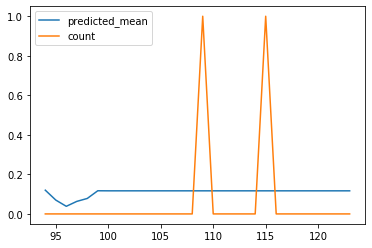

In [307]:
pred.plot(legend=True)
test['count'].plot(legend=True)

In [308]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(pred, test['count']))
rmse

0.25198569536195214

In [309]:
test['count'].mean()

0.06666666666666667